## 参照状態

このレッスンでは、変分アルゴリズムをより速く収束させるために、参照状態で系を初期化する方法について学びます。まず、 [*参照状態*](gloss:reference) を手動で構築する方法を学び、次に変分アルゴリズムで使用可能ないくつかの標準的な選択肢を探ります。

![Reference Workflow](images/reference_workflow.png)

## デフォルト状態

*参照状態* とは、問題に対する最初の固定開始状態を意味します。参照状態を準備するために、量子回路の開始時に適切なパラメータ化されていないユニタリー回路 $U_R$ を適用し、 $|\rho\rangle = U_R |0\rangle$ となるようにする必要があります。既存の最適解からの推測やデータ点がある場合、それを出発点として使用すると変分アルゴリズムが早く収束する可能性があります。

最も単純な参照状態はデフォルト状態であり、 $n$ 量子ビット回路の開始状態 $|0\rangle^{\otimes n}$ を使用します。 デフォルト状態の場合、ユニタリー演算子 $U_R \equiv I$ が使われます。その単純さゆえに、デフォルト状態は多くのシナリオで使用される有効な参照状態です。

## 古典的な参照状態

$3$ 量子ビット系で、デフォルトの状態 $|000\rangle$ の代わりに状態 $|001\rangle$ で始めたいとします。これは純粋に古典的な参照状態の例で、これを構築するには、(Qiskitの量子ビット順序に従って)量子ビット $0$ に [X ゲート](https://qiskit.org/documentation/stubs/qiskit.circuit.library.XGate.html)  を適用するだけで、 $|001\rangle = X_0 |000\rangle$ となります。

この場合、ユニタリー演算子は $U_R \equiv X_0$ となり、参照状態 $|\rho\rangle \equiv |001\rangle$ を作ります。

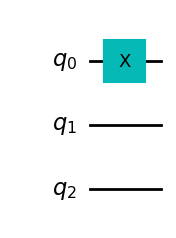

In [1]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(3)
qc.x(0)

qc.draw("mpl")

## 量子的な参照状態

例えば、 $\frac{1}{\sqrt{2}}(|100\rangle+|111\rangle)$ のような重ね合わせやエンタングルメントを含むより複雑な状態から始めたいとします。

この状態を $|000\rangle$ から得る方法の一つに、量子ビット $0$ に対して [アダマールゲート](https://qiskit.org/documentation/stubs/qiskit.circuit.library.HGate.html)（ $H_0$ ）、量子ビット $0$ を制御量子ビット、量子ビット $1$ をターゲット量子ビットとする [CNOT（CX）](https://qiskit.org/documentation/stubs/qiskit.circuit.library.CXGate.html)ゲート（ $CNOT_{01}$ ）、最後に量子ビット $2$ に対する $X$ ゲート（ $X_2$ ）を適用する方法があります。

このとき、ユニタリー演算子は $U_{R} \equiv X_2CNOT_{01}H_0|000\rangle$ 、参照状態は $|\rho\rangle \equiv \frac{1}{\sqrt{2}}(|100\rangle+|111\rangle)$ です。

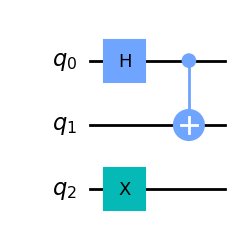

In [2]:
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.x(2)

qc.draw("mpl")

## テンプレート回路を用いた参照状態の構築

また、複数の調整可能なパラメータやエンタングルメントを簡単に表現できる [`TwoLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html) など、様々なテンプレート回路を利用することができます。これらのテンプレート回路については、次回のレッスンで詳しく説明しますが、パラメータをバインドした *場合* 、参照状態に利用することができます。

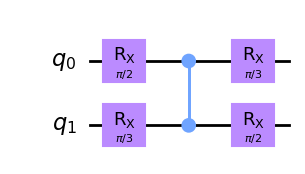

In [3]:
from qiskit.circuit.library import TwoLocal
from math import pi

reference_circuit = TwoLocal(2, "rx", "cz", entanglement="linear", reps=1)
theta_list = [pi / 2, pi / 3, pi / 3, pi / 2]

reference_circuit = reference_circuit.bind_parameters(theta_list)

reference_circuit.decompose().draw("mpl")

## アプリケーション固有の参照状態

### 量子化学

量子化学では、 *Hartree-Fock* 状態は原子や分子の基底状態の近似値です。正確な基底状態を求める変分アルゴリズムを作成することが目的であれば、この既知の古典的近似を参照状態として使用することで、アルゴリズムの収束を早くすることができます。

この例では、2つの空間軌道と2つの電子（1つのアルファ・スピン、1つのベータ・スピン）を持つ問題に対して、次のように電子構造の問題を生成することができます。

/opt/conda/lib/python3.10/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


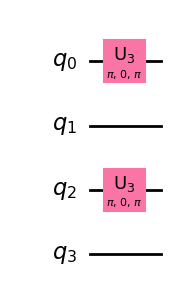

In [4]:
from qiskit_nature.second_q.circuit.library import HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper

num_spatial_orbitals = 2
num_particles = (1, 1)

mapper = JordanWignerMapper()

h2_reference_state = HartreeFock(
    num_spatial_orbitals=num_spatial_orbitals,
    num_particles=num_particles,
    qubit_mapper=mapper,
)

h2_reference_state.decompose().draw("mpl")

また、水素化リチウム（LiH）のような特定の分子を構成することも可能です。

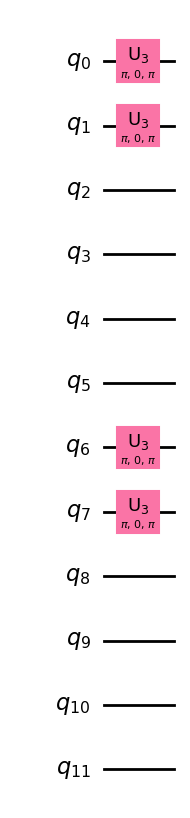

In [5]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo

molecule = MoleculeInfo(
    # Coordinates in Angstrom
    symbols=["Li", "H"],
    coords=([0.0, 0.0, 0.0], [0.2, 0.0, 0.0]),
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)

driver = PySCFDriver.from_molecule(molecule)
LiH_problem = driver.run()

mapper = JordanWignerMapper()
LiH_reference_state = HartreeFock(
    num_spatial_orbitals=LiH_problem.num_spatial_orbitals,
    num_particles=LiH_problem.num_particles,
    qubit_mapper=mapper,
)

LiH_reference_state.decompose().draw("mpl")

### 量子機械学習

[変分量子分類器（VQC）](https://learn.qiskit.org/course/machine-learning/variational-classification) の文脈では、訓練データは、 *特徴量マップ* として知られるパラメータ化された回路で量子状態に符号化され、各パラメータの値は訓練データセットのデータ点を表します。 [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html) は、この特徴量マップにデータ点($x$) を渡すパラメータ化回路の一種です。

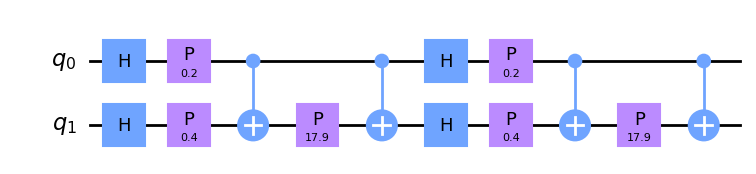

In [6]:
from qiskit.circuit.library import ZZFeatureMap

data = [0.1, 0.2]

zz_feature_map_reference = ZZFeatureMap(feature_dimension=2, reps=2)
zz_feature_map_reference = zz_feature_map_reference.bind_parameters(data)
zz_feature_map_reference.decompose().draw("mpl")

このレッスンで、あなたは、以下を使ってシステムを初期化する方法を学びました：

- デフォルトの参照状態
- 古典的な参照状態
- 量子的な参照状態
- アプリケーション固有の参照状態

このハイレベルな変分ワークロードは次のようになります。

![Reference Circuit](images/reference_circuit.png)

参照状態は固定された最初の出発点であるのに対し、 *変分形式* を使って、変分アルゴリズムが探索するためのパラメータ化された状態の集合を表す *ansatz* を定義することができます。